# HDDM models results summary

Imports

In [90]:
from cmdstanpy import CmdStanModel
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import cmdstanpy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Read the MCMC fit object from csv files

In [1139]:
model = 'stahl_spe_boundary_ncond_tbb_warmup-5000_samples-10000_thin-5'
path = '../cmd_results/stahl/spe/'
# path = '../plgrid_results/cond_models/sonata/'

In [1140]:
fit = cmdstanpy.from_csv(path=f'{path}/{model}/')

20:51:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [1141]:
print(fit.diagnose())

Processing csv files: ../cmd_results/stahl/spe//stahl_spe_boundary_ncond_tbb_warmup-5000_samples-10000_thin-5/wiener_boundary_ncond_tbb_model-20240528160249_4.csv, ../cmd_results/stahl/spe//stahl_spe_boundary_ncond_tbb_warmup-5000_samples-10000_thin-5/wiener_boundary_ncond_tbb_model-20240528160249_3.csv, ../cmd_results/stahl/spe//stahl_spe_boundary_ncond_tbb_warmup-5000_samples-10000_thin-5/wiener_boundary_ncond_tbb_model-20240528160249_2.csv, ../cmd_results/stahl/spe//stahl_spe_boundary_ncond_tbb_warmup-5000_samples-10000_thin-5/wiener_boundary_ncond_tbb_model-20240528160249_1.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 8000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checkin

## Results summary

### Save draws

In [1142]:
# fit_df = fit.draws_pd()
# fit_df.to_csv(f'{path}/{model}/results/{model}_samples.csv')

### Create and save the summary

mean, stdv, percentiles, n_effects, r_hats, bayes factors

In [1143]:
def calculate_bayes_factor_participant_level(
        fit_df, 
        parameters_list, 
        prior_distribution, 
        hierarchical=False
):
    prior_kde_0 = calculate_hierarchical_prior_kde(prior_distribution, N=100000)(0)
    
    participants_bf_01 = []

    for participants_parameter in parameters_list:
        participant_bf_01 = calculate_bayes_factor(fit_df, participants_parameter, prior_kde_0)
        participants_bf_01.append(participant_bf_01)

    return np.array(participants_bf_01).flatten()

In [1144]:
def calculate_hierarchical_prior_kde(hyper_prior_distributions, N = 100000):
    if isinstance(hyper_prior_distributions, list):
        prior_samples = []
        for hyper_prior in hyper_prior_distributions:
            mean_hyper_prior = hyper_prior['mean']
            sd_hyper_prior = hyper_prior['sd']

            mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
            sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))

            for i in range(0,N):
                prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
                prior_samples.append(prior_sample)
        prior_samples = np.array(prior_samples)
                
    else:
        mean_hyper_prior = hyper_prior_distributions['mean']
        sd_hyper_prior = hyper_prior_distributions['sd']
        
        mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
        sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))
        
        prior_samples = []
        for i in range(0,N):
            prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
            prior_samples.append(prior_sample)
        prior_samples = np.array(prior_samples)
        
    # Prior density of hierarchical effect parameters
    prior_density = stats.gaussian_kde(prior_samples)
    
    return prior_density

In [1145]:
def calculate_bayes_factor(fit_df, parameter, prior_kde):
    parameter_samples = fit_df[parameter].to_numpy()

    # Estimate density curves from samples
    parameter_kde = stats.gaussian_kde(parameter_samples)

    # Calculate Bayes Factors 01, evidence for the null hypothesis
    bayes_factor_01 = parameter_kde(0) / prior_kde

    return bayes_factor_01

In [1146]:
def get_summary_with_bayes_factor(fit, priors_dict, variables_to_track):
    fit_df = fit.draws_pd()
    bayes_factors = dict()
    
    for parameter_name in priors_dict.keys():
        prior_kde, is_hierarchical = priors_dict[parameter_name]
    
        if is_hierarchical:
            parameters_list = [variable for variable in variables_to_track if parameter_name in variable ]
            
            participants_bf_01 = calculate_bayes_factor_participant_level(
                fit_df,
                parameters_list=parameters_list,
                prior_distribution = prior_kde,
                hierarchical=True
            )
            bayes_factors_hierarchical = dict(zip(parameters_list, participants_bf_01))
            bayes_factors.update(bayes_factors_hierarchical)
        else:
            if isinstance(prior_kde, list):
                print('dupa')
                prior_kde = np.mean(prior_kde)
                
            bf_01 = calculate_bayes_factor(
                fit_df, 
                parameter=parameter_name,
                prior_kde = prior_kde,
            )
            bayes_factors_population = dict(zip([parameter_name], bf_01))
            bayes_factors.update(bayes_factors_population)
        
    summary_df = fit.summary(percentiles=(2, 98))
    bayes_factors_df = pd.DataFrame.from_dict(bayes_factors, orient='index', columns=['Bayes_factor'])
    result_df = pd.concat([summary_df, bayes_factors_df], axis=1)

    return result_df

Define priors

In [1147]:
# # columns: prior, is hierarchical || model = drift_boundary
priors_dict = {
    # 'participants_alpha_cond':[{
    #     'mean': {'loc':0, "scale":1},
    #     'sd': {'shape':1, "scale":1},
    # }, True],
    'participants_alpha_ne':[{
        'mean': {'loc':0, "scale":0.2},
        'sd': {'shape':.3, "scale":1},
    }, True],
    # 'participants_alpha_ne_pre_acc':[{
    #     'mean': {'loc':0, "scale":0.2},
    #     'sd': {'shape':.3, "scale":1},
    # }, True],
    # 'participants_alpha_ern':[[{
    #     'mean': {'loc':0, "scale":0.2},
    #     'sd': {'shape':.3, "scale":1},
    # }, {
    #     'mean': {'loc':0, "scale":0.2},
    #     'sd': {'shape':.3, "scale":1},
    # }], True],
    # 'participants_delta_cond': [{
    #     'mean': {'loc':0, "scale":2},
    #     'sd': {'shape':1, "scale":1},
    # }, True],
    # 'participants_delta_ne': [{
    #     'mean': {'loc':0, "scale":.5},
    #     'sd': {'shape':.3, "scale":1},
    # }, True],
    # 'participants_delta_ne_pre_acc':[{
    #     'mean': {'loc':0, "scale":0.5},
    #     'sd': {'shape':.3, "scale":1},
    # }, True],
    # 'participants_delta_ern':[[{
    #     'mean': {'loc':0, "scale":0.5},
    #     'sd': {'shape':.3, "scale":1},
    # }, {
    #     'mean': {'loc':0, "scale":0.5},
    #     'sd': {'shape':.3, "scale":1},
    # }], True],
    # 'alpha_cond': [stats.norm.pdf(0, loc=0, scale=1), False],
    'alpha_ne': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    # 'alpha_ern': [[stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.2)], False],
    # 'delta_cond': [stats.norm.pdf(0, loc=0, scale=2), False],
    # 'delta_ne': [stats.norm.pdf(0, loc=0, scale=.5), False],
    # 'delta_ern': [[stats.norm.pdf(0, loc=0, scale=0.5), stats.norm.pdf(0, loc=0, scale=0.5)], False],
    
    'alpha_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    'alpha_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    # 'alpha_ne_cond': [stats.norm.pdf(0, loc=0, scale=0.2), False],
    # 'alpha_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=0.2), False],
    # 'alpha_ne_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=0.2), False],
   
    # 'delta_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
    # 'delta_ne_pre_acc': [stats.norm.pdf(0, loc=0, scale=.5), False],
    # 'delta_ne_cond': [stats.norm.pdf(0, loc=0, scale=.5), False],
    # 'delta_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=.5), False],
    # 'delta_ne_pre_acc_cond':[stats.norm.pdf(0, loc=0, scale=.5), False],
}

In [1148]:
model_variables = list(fit.method_variables().keys()) + ['chain__', 'iter__', 'draw__']
variables_to_track = fit.draws_pd().columns.to_numpy()
variables_to_track = [variable for variable in variables_to_track if ('log_lik' not in variable and variable not in model_variables)]

try:
    summary = get_summary_with_bayes_factor(fit, priors_dict, variables_to_track)
    summary.to_csv(f'{path}/{model}/results/{model}_summary_with_bf_plgrid_test.csv')
except Exception as e:
    print(e)
    print('Saving summary without bayes factors')
    summary = fit.summary()
    summary.to_csv(f'{path}/{model}/results/{model}_summary.csv')

### Calculate WAIC

In [1149]:
def waic(log_likelihood):
    """Calculates the Watanabe-Akaike information criteria.
    Calculates pWAIC1 and pWAIC2
    according to http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    Parameters
    ----------
    pointwise : bool, default to False
        By default, gives the averaged waic.
        Set to True is you want additional waic per observation.
    Returns
    -------
    out: dict
        Dictionary containing lppd (log pointwise predictive density),
        p_waic, waic, waic_se (standard error of the waic), and
        pointwise_waic (when `pointwise` is True).
    """

    N = log_likelihood.shape[1]
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(N * np.var(pointwise_waic))

    model_statistics = {'lppd':lppd,
           'p_waic':var_l,
           'waic':waic,
           'waic_se':waic_se}
    return model_statistics

In [1150]:
fit_df = fit.draws_pd()

log_likelihood_columns = [col for col in fit_df.columns if 'log_lik' in col]
log_likelihood = fit_df[log_likelihood_columns].to_numpy()

model_statistics = waic(log_likelihood)
model_statistics_df = pd.DataFrame.from_dict(model_statistics, orient='index', columns=['value'])

display(model_statistics_df)

model_statistics_df.to_csv(f'{path}/{model}/results/{model}_model_statistics.csv')

,value
lppd,-708.261473
p_waic,196.115293
waic,1808.753532
waic_se,143.533103


## Plots

In [1151]:
model_variables = list(fit.method_variables().keys()) + ['chain__', 'iter__', 'draw__']
variables_to_track = fit.draws_pd().columns.to_numpy()
variables_to_track = [variable for variable in variables_to_track if ('log_lik' not in variable and variable not in model_variables)]
base_variables_to_track = [variable for variable in variables_to_track if 'participant' not in variable] + ['chain__', 'iter__'] 

fit_df = fit.draws_pd()
fit_df_params = fit_df[base_variables_to_track]
melted_fit_df_params = pd.melt(fit_df_params, id_vars=['chain__', 'iter__'], var_name='parameter', value_name='value')

### Draw chains

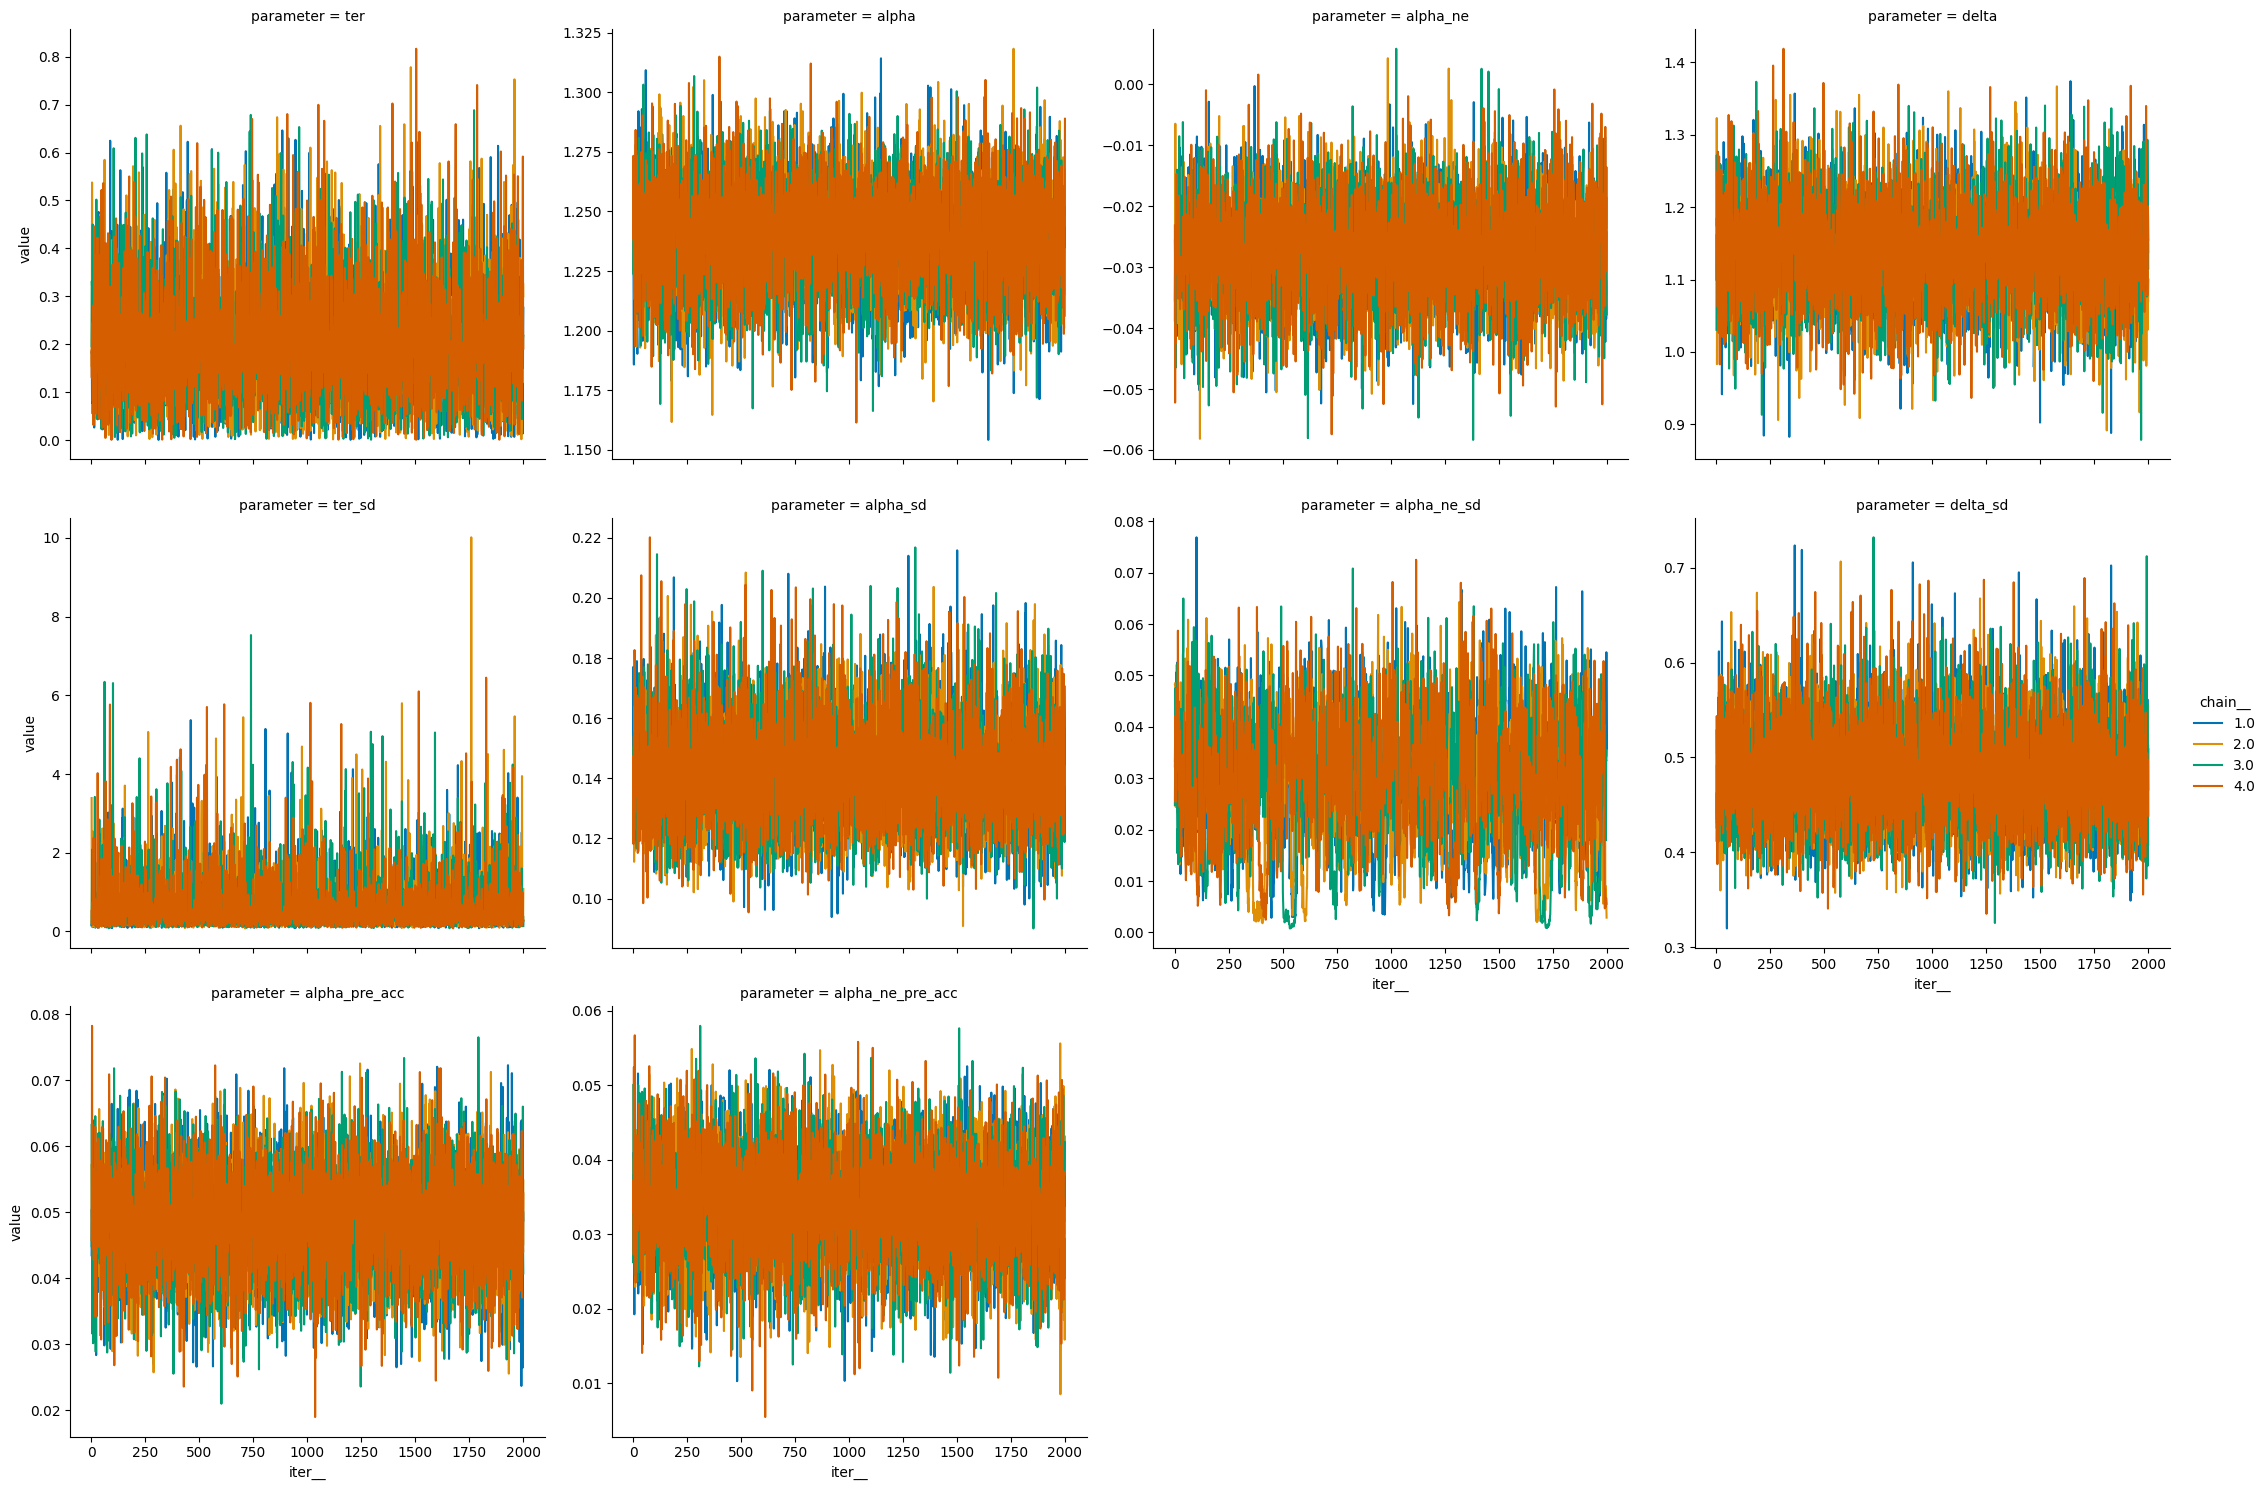

In [1152]:
g = sns.relplot(
    data=melted_fit_df_params,
    x="iter__", 
    y="value",
    hue="chain__", 
    col="parameter",
    kind="line",
    col_wrap=4,
    height=5, 
    aspect=1.1, 
    facet_kws=dict(sharex=True, sharey=False),
    palette='colorblind'
)

fig = plt.gcf()

plt.savefig(f'{path}/{model}/results/{model}_chains.png', bbox_inches='tight')

### Draw base parameters distributions

In [1153]:
# # Function to plot KDE with CI
# def plot_kde_with_colored_ci(data, **kwargs):
#     kde = sns.kdeplot(data=data['value'], **kwargs)

#     # Extract the KDE line data
#     x, y = kde.get_lines()[0].get_data()
#     # kde.remove()

#     # Calculate the 5th and 95th percentiles
#     lower = np.percentile(data['value'], 5)
#     upper = np.percentile(data['value'], 95)

#     # Plot the entire KDE
#     plt.plot(x, y, color='b')

#     # Fill the area between the 5th and 95th percentiles
#     plt.fill_between(x, y, where=(x >= lower) & (x <= upper), color='g', alpha=0.5)

#     # Draw vertical lines for percentiles and mean
#     mean = np.mean(data['value'])
#     # plt.axvline(lower, color='k', linestyle='--')
#     # plt.axvline(upper, color='k', linestyle='--')
#     plt.axvline(mean, color='r', linestyle='-')

# # Create the FacetGrid
# g = sns.FacetGrid(melted_fit_df_params, col="parameter", col_wrap=4, sharey=False, sharex=False,)

# # Map the plot_kde_with_colored_ci function to each facet
# g.map_dataframe(plot_kde_with_colored_ci)

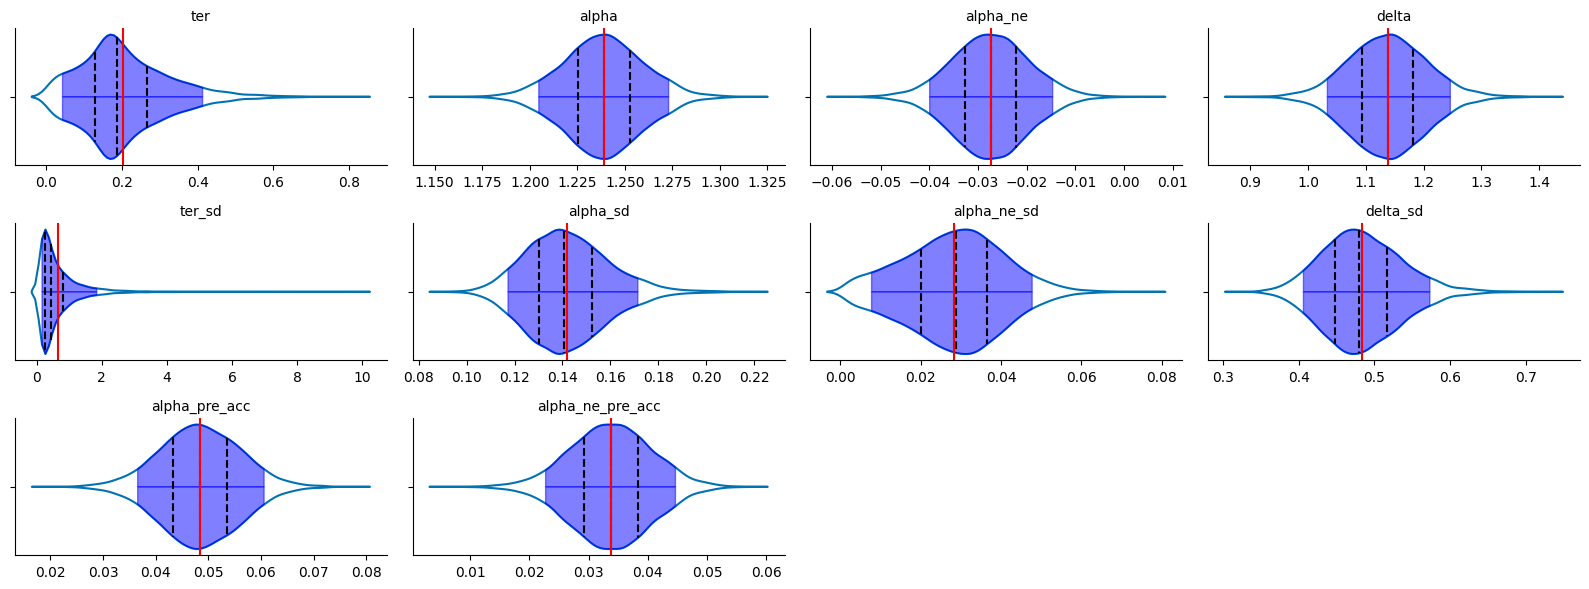

In [1154]:
def plot_violin_with_colored_ci(data, **kwargs):
    subset = data
    lower = np.percentile(subset['value'], 5)
    upper = np.percentile(subset['value'], 95)
    mean = np.mean(subset['value'])
    
    violin = sns.violinplot(x='value', data=data, fill=False, inner='quart', **kwargs)
    path_data = violin.get_children()[0].get_paths()
    x = path_data[0].vertices[:, 0]
    y = path_data[0].vertices[:, 1]    

    plt.fill_between(x, y, where=(x >= lower) & (x <= upper), color='blue', alpha=0.5)
    
    for l in violin.lines:
        l.set_linestyle('--')
        l.set_linewidth(1.5)
        l.set_color('black')
    
    plt.axvline(mean, color='r', linestyle='-')

g = sns.FacetGrid(
    melted_fit_df_params, 
    col="parameter", 
    sharex=False, 
    sharey=False, 
    col_wrap=4,
    palette='colorblind',
    aspect=2,
    height=2,
)
g.set_titles(col_template="{col_name}")
g.map_dataframe(plot_violin_with_colored_ci)
g.set_ylabels("")
g.set_xlabels("")

g.fig.tight_layout()

fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_distributions.png', bbox_inches='tight')

### Pair-plots of base parameters
To check cross-parameter correlations

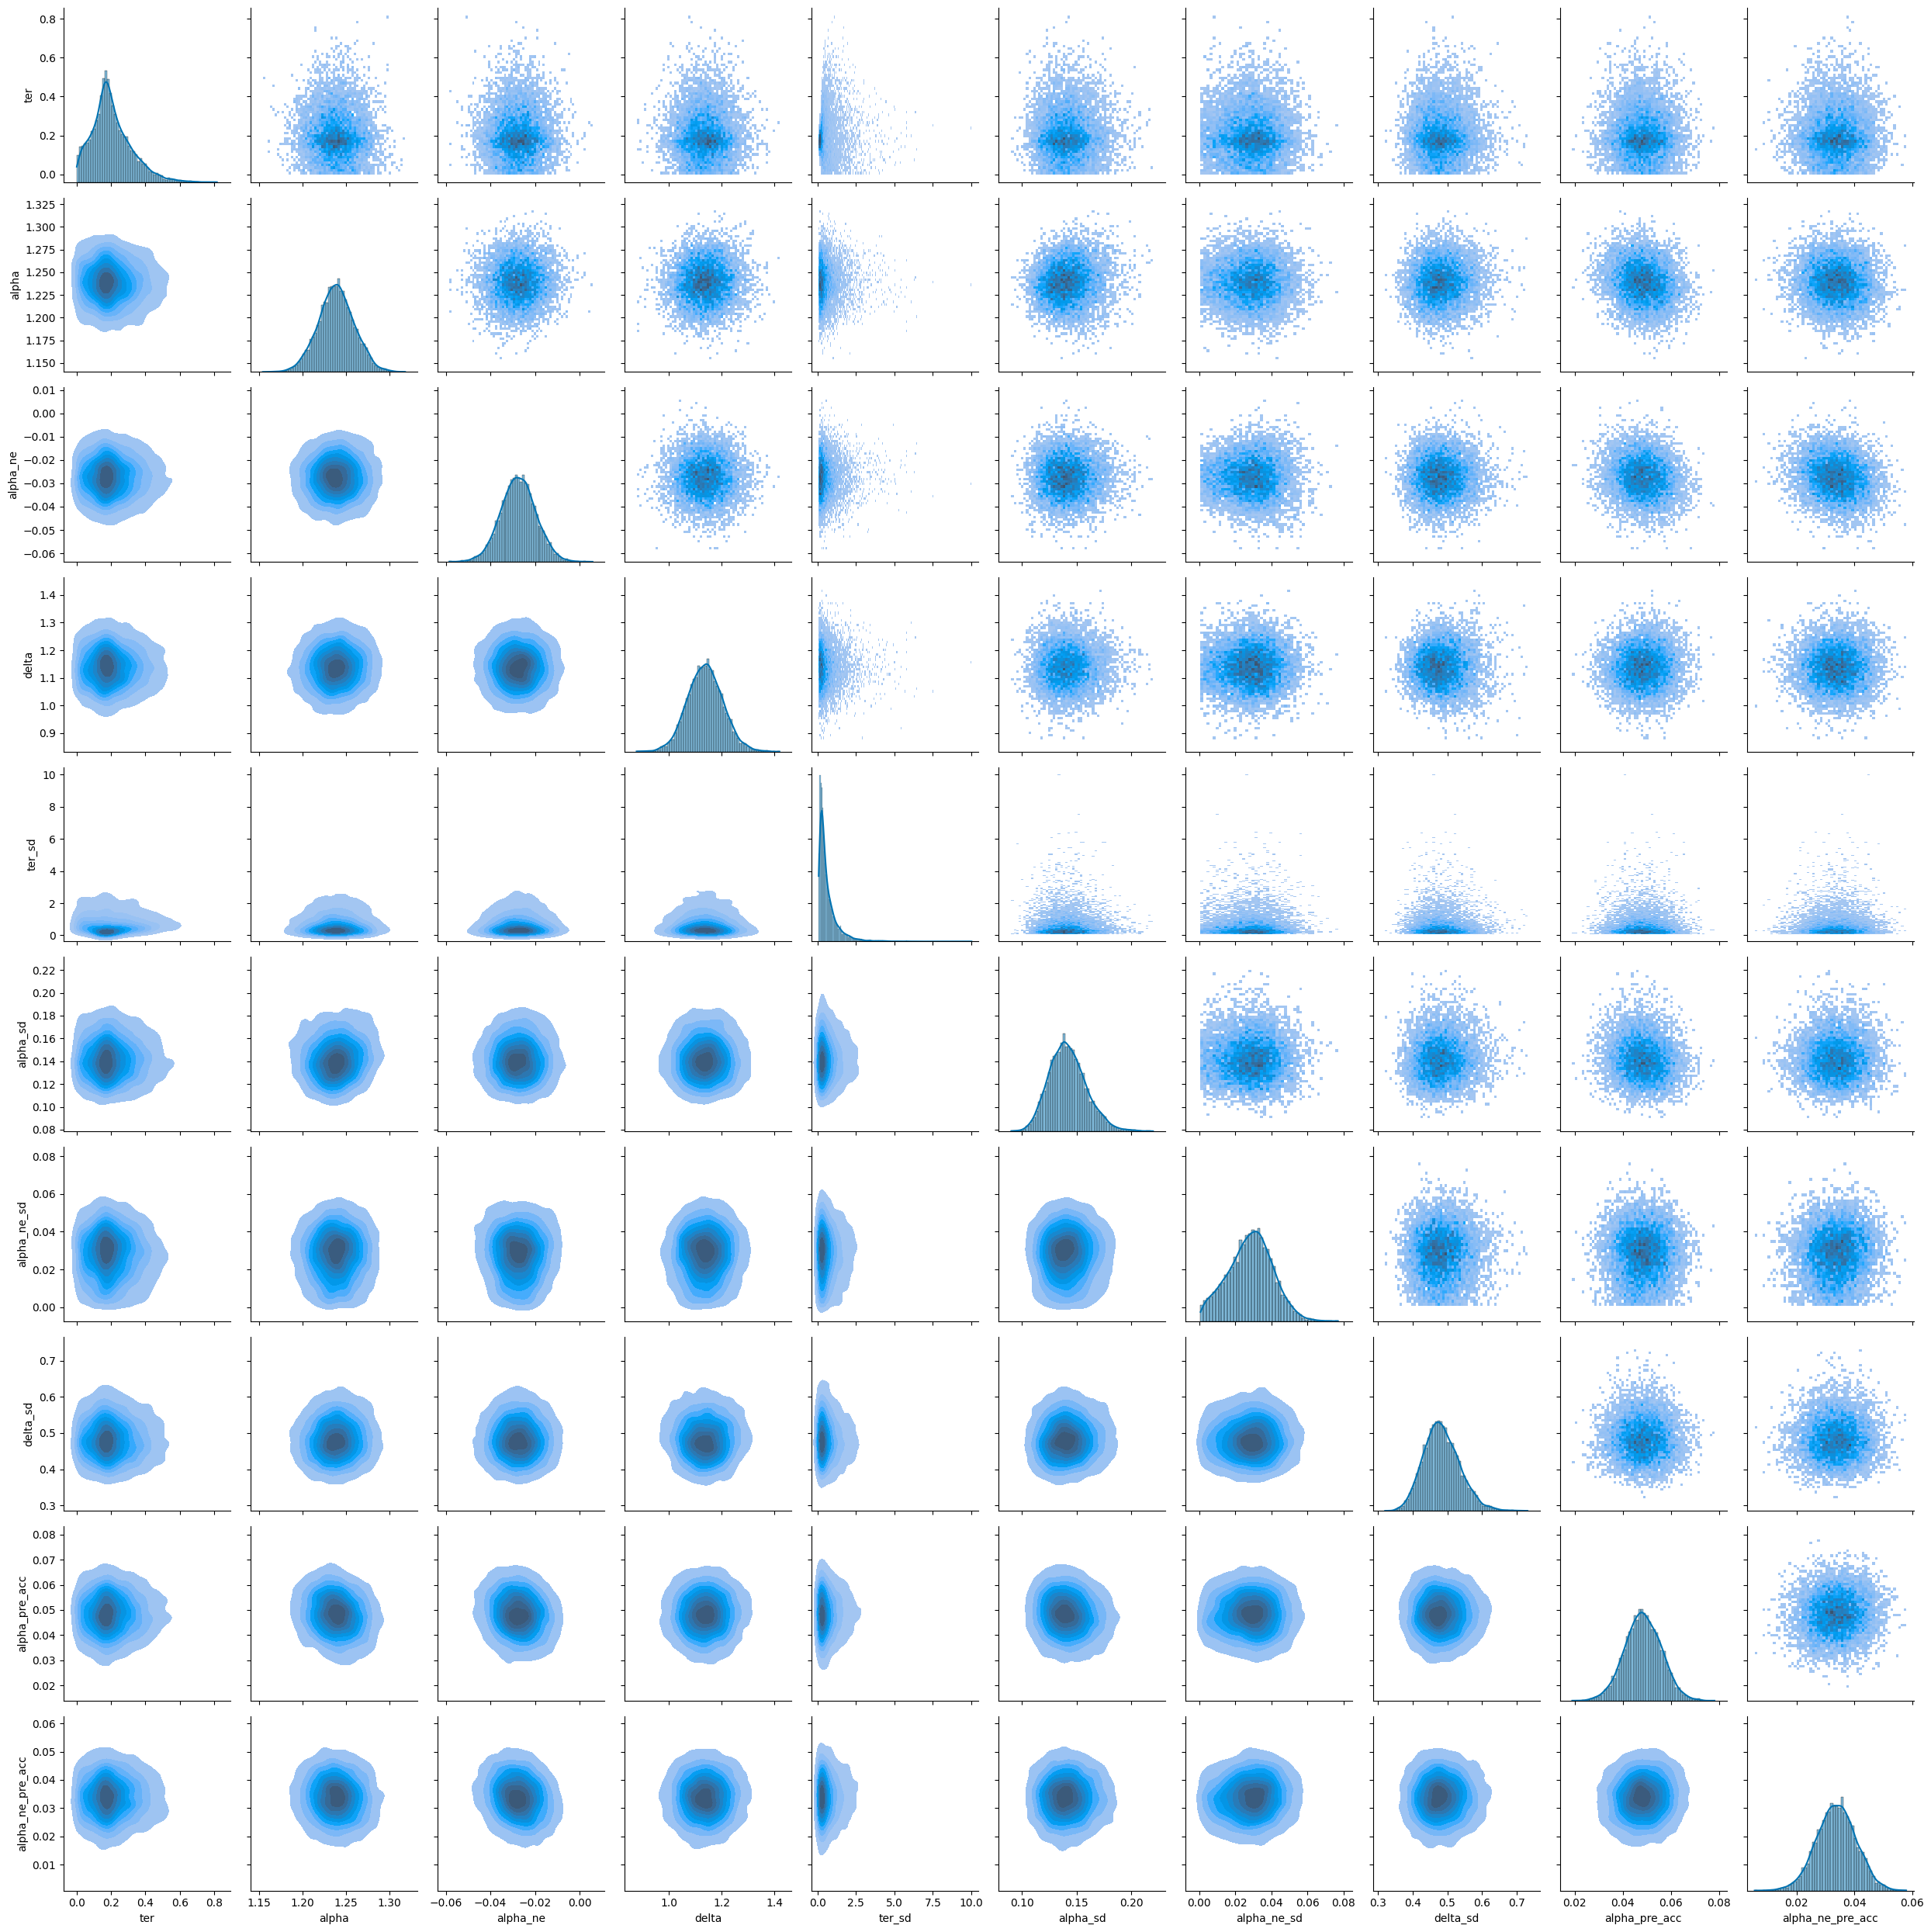

In [1155]:
base_variables_to_track = [variable for variable in variables_to_track if 'participant' not in variable]
fit_df = fit.draws_pd()
fit_df_params = fit_df[base_variables_to_track]

g = sns.PairGrid(fit_df_params)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

g.fig.tight_layout()
fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_pair_plots.png', bbox_inches='tight')

### Bayes factors distributions

In [1156]:
summary_copy = summary.copy()
summary_copy['parameter_name'] = summary_copy.index.str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)
summary_copy.groupby(['parameter_name']).agg(['min', 'max', 'median']).to_csv(f'{path}/{model}/results/{model}_parameters_aggegation.csv')

summary_copy_random_effects = summary_copy[(~summary_copy['Bayes_factor'].isna()) & (summary_copy['parameter_name'].str.contains('participants', case=False, na=False))]
summary_copy_random_effects.reset_index(inplace=True)
summary_copy_random_effects = summary_copy_random_effects.sort_values(by=['parameter_name', 'Bayes_factor'])

/home/anna/Work/jointError_cmd_test/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


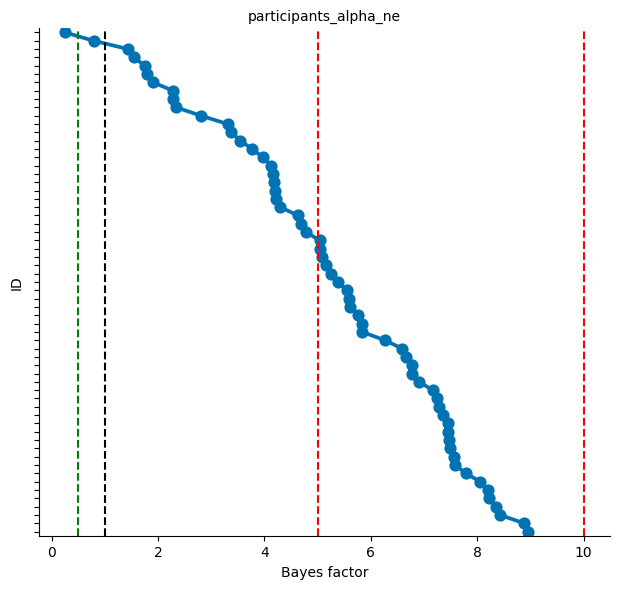

In [1157]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    summary_copy_random_effects, 
    col='parameter_name', 
    col_wrap=3, 
    sharey=False,
    sharex=False,
    aspect=1,
    height=6,
)

g.map(
    sns.pointplot, 
    'Bayes_factor', 
    'index', 
)

g.set_yticklabels([])
g.set_axis_labels("Bayes factor", "ID")
g.set_titles(col_template="{col_name}")

# Add vertical lines at x-values 0.1 and 10
def add_vertical_lines(x, color, linestyle):
    plt.axvline(x=x, color=color, linestyle=linestyle)
    
g.map(add_vertical_lines, color='g', linestyle='--', x=0.5)
g.map(add_vertical_lines, color='black', linestyle='--', x=1)
g.map(add_vertical_lines, color='r', linestyle='--', x=10)
g.map(add_vertical_lines, color='r', linestyle='--', x=5)


g.fig.tight_layout()

fig = plt.gcf()
plt.savefig(f'{path}/{model}/results/{model}_random_effects_bfs.png', bbox_inches='tight')

----

### Test priors

In [907]:
priors_dict = {
    'participants_delta_ne':[{
        'mean': {'loc':0, "scale":0.5},
        'sd': {'shape':0.3, "scale":1},
    }, True],
    'participants_alpha_ne_pre_acc':[{
        'mean': {'loc':0, "scale":0.1},
        'sd': {'shape':1, "scale":1},
    }, True],
    'participants_alpha_ern':[
        [
            {
                'mean': {'loc':0, "scale":0.5},
                'sd': {'shape':1, "scale":1},
            },
            {
                'mean': {'loc':0, "scale":0.1},
                'sd': {'shape':1, "scale":1},
            },
        ], 
        True
    ],
}

In [908]:
hyper_prior_distributions = priors_dict['participants_delta_ne'][0]
N=10000

In [909]:
mean_hyper_prior = hyper_prior_distributions['mean']
sd_hyper_prior = hyper_prior_distributions['sd']

mean_samples = np.random.normal(loc=mean_hyper_prior['loc'], scale=mean_hyper_prior['scale'], size=(N,))
sd_samples = np.random.gamma(shape = sd_hyper_prior['shape'], scale=sd_hyper_prior['scale'], size=(N,))

prior_samples = []

for i in range(0,N):
    prior_sample = np.random.normal(loc=mean_samples[i], scale=sd_samples[i], size=None)
    prior_samples.append(prior_sample)
prior_samples = np.array(prior_samples)

x_vals = np.linspace(-1, 1, 1000)

# Prior density of hierarchical effect parameters
prior_density = stats.gaussian_kde(prior_samples)

parameter_kde = stats.gaussian_kde(fit.draws_pd()['participants_delta_ne[209]'])

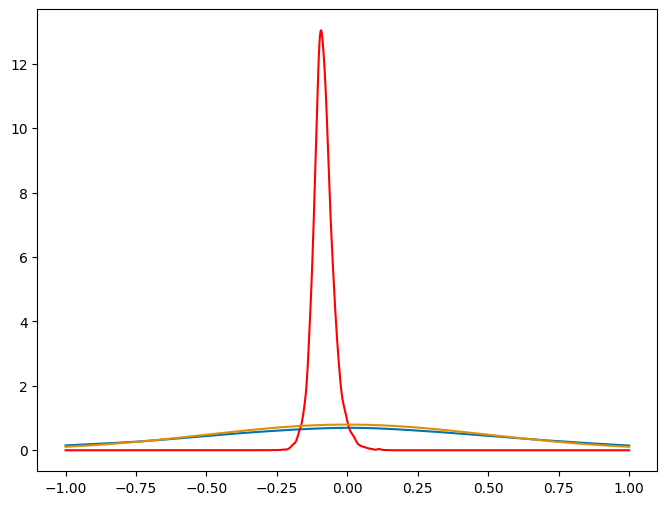

In [917]:
# Generate a range of values over which to evaluate the density

# Evaluate the density
y_vals = prior_density(x_vals)
y_sample_vals = parameter_kde(x_vals)
y_sample2_values = stats.norm.pdf(x_vals, loc=0, scale=0.5)


# Plot the density using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Gaussian KDE')
plt.plot(x_vals, y_sample_vals, label='Gaussian KDE', color='r')
plt.plot(x_vals, y_sample2_values, label='Gaussian KDE')

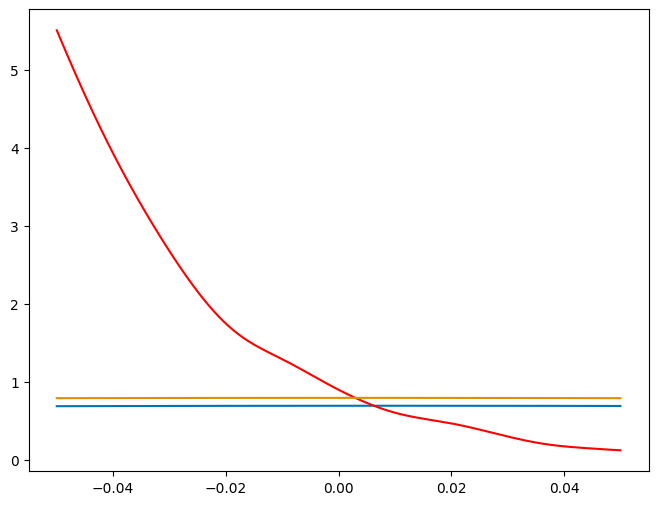

In [916]:
# Generate a range of values over which to evaluate the density
x_zoom = np.linspace(-0.05, 0.05, 1000)

y_vals = prior_density(x_zoom)
y_sample_vals = parameter_kde(x_zoom)
y_sample2_values = stats.norm.pdf(x_zoom, loc=0, scale=0.5)

# Plot the density using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(x_zoom, y_vals, label='Gaussian KDE')
plt.plot(x_zoom, y_sample_vals, label='Gaussian KDE', color='r')
plt.plot(x_zoom, y_sample2_values, label='Gaussian KDE')

<Axes: ylabel='Count'>

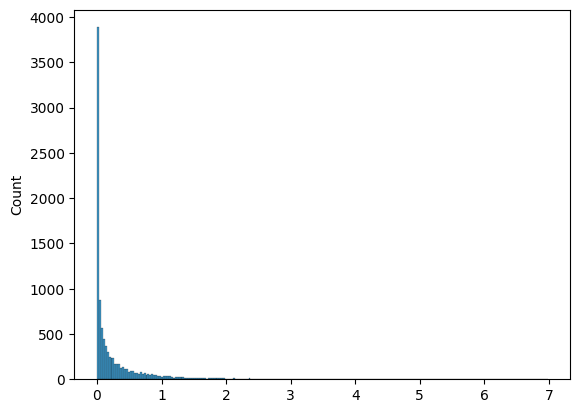

In [913]:
sns.histplot(sd_samples)

In [914]:
# Calculate Bayes Factors 01, evidence for the null hypothesis
bayes_factor_01 = parameter_kde(0) / prior_density(0)
print(bayes_factor_01)

bayes_factor_01 = parameter_kde(0) / stats.norm.pdf(0, loc=0, scale=0.2)
print(bayes_factor_01)

[1.29372555]
[0.4519894]


<Axes: xlabel='participants_delta_ne[209]', ylabel='Count'>

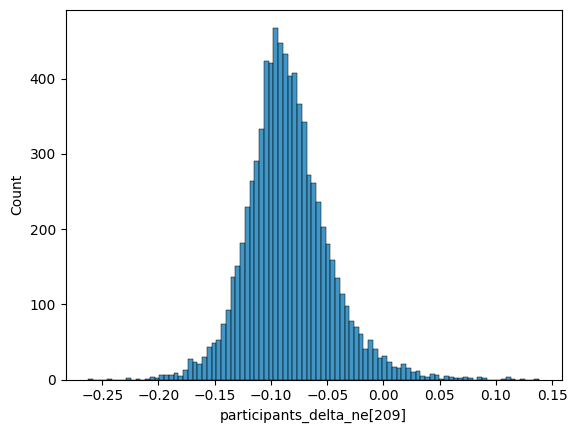

In [915]:
sns.histplot(fit.draws_pd()['participants_delta_ne[209]'])

# up to 10 - it is
# up to 25 - maybe
# above 25 - there is no

In [1089]:
N = 100000
mean_samples_1 = np.random.normal(loc=0, scale=0.2, size=(N,))
mean_samples_2 = np.random.normal(loc=0, scale=0.5, size=(N,))

prior_samples =  np.concatenate((mean_samples_1, mean_samples_2))
x_vals = np.linspace(-1, 1, 100000)

# Prior density of hierarchical effect parameters
prior_density = stats.gaussian_kde(prior_samples)

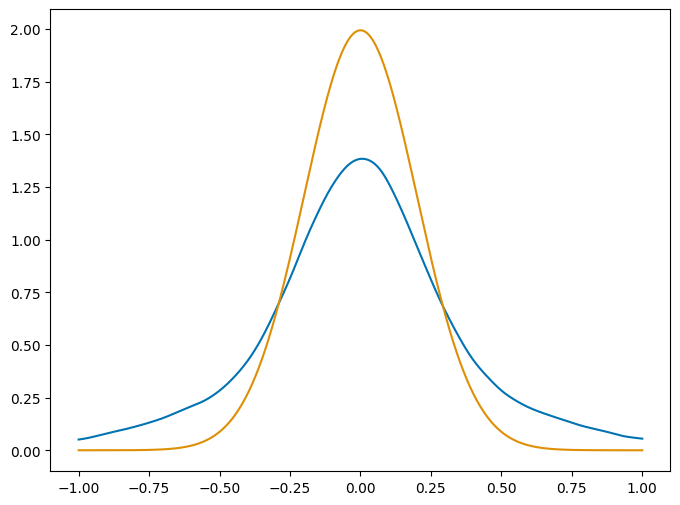

In [1090]:
# Evaluate the density
y_vals = prior_density(x_vals)
y_sample2_values = stats.norm.pdf(x_vals, loc=0, scale=0.2)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Gaussian KDE')
plt.plot(x_vals, y_sample2_values, label='Gaussian KDE')

In [1091]:
len(prior_samples)

200000

In [1092]:
prior_density(0)

array([1.38394924])

In [1095]:
prior_kde = [stats.norm.pdf(0, loc=0, scale=0.2), stats.norm.pdf(0, loc=0, scale=0.5)]
prior_kde = np.mean(prior_kde)

In [1096]:
prior_kde

1.3962979814050145